# Imports and Helper/Utility Methods

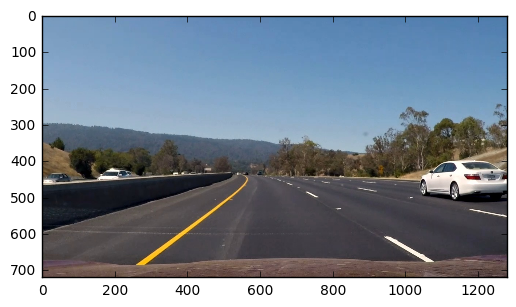

In [175]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import random
import time
import math

from scipy.ndimage.measurements import label

from features import SupportVectorClassifier
from features import FeatureExtractor
from features import DataLoader
from features import ImageSampler

def seconds_elapsed_since(start_time):
    return round(time.time() - start_time)

def show_images(images, per_row=None, main_title=None):

    if per_row = None:
        per_row = math.ceil(math.sqrt(len(images)))
        
    figure = plt.figure(1)

    for n, img in enumerate(images):
        ax = figure.add_subplot(np.ceil(len(images) / per_row), per_row, n + 1)

        ax.grid(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis("off")

        plt.imshow(img)
    if main_title is not None:
        plt.suptitle(main_title)

    plt.show()
    
def save_to_pickle(in_data, key, path):
    """
    Saves data to specified pickle file.
    """
    data = {}
    try:
        with open(path, 'rb') as file:
            data = pickle.load(file)
    except FileNotFoundError:
        print("Creating new pickle file")

    with open(path, 'wb') as file:
        data[key] = in_data
        pickle.dump(data, file)

def load_from_pickle(key, path):
    """
    Loads saved data from specified pickle file.
    """
    try:
        with open(path, 'rb') as file:
            data = pickle.load(file)
            if key not in data:
                return None
    except FileNotFoundError:
        return None

    return data[key]

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    count = 0

    # Iterate through the bounding boxes
    for bbox in bboxes:
        color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        count += 1
    # Return the image copy with boxes drawn
    return imcopy

img = cv2.imread('project_video_images/frame240.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


# Loading and Exploring The Data Set

Vehicle Images:
   Count:       8792 of 17760 (49.50%)
   Value Range: 0 to 255
   Shape:       64 x 64


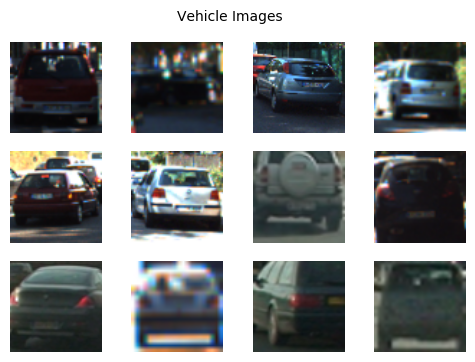



Non Vehicle Images:
   Count:       8968 of 17760 (50.50%)
   Value Range: 0 to 255
   Shape:       64 x 64


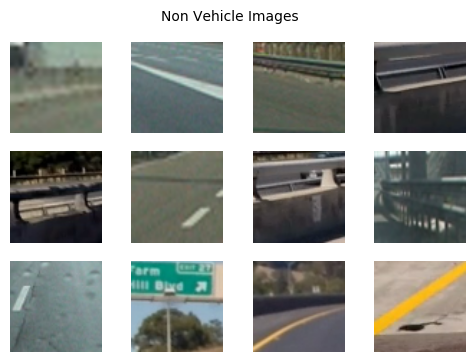

In [4]:
def explore_data(title, data, total_count, image_sample_count=12):
    count = len(data)
    percentage_of_total = count * 100.0 / total_count
    shape = data[0].shape
    minmax_range = (np.amin(data), np.amax(data))
    
    print('{:s}:'.format(title))
    print('   Count:       {:d} of {:d} ({:3.2f}%)'.format(count, total_count, percentage_of_total))
    print('   Value Range: {} to {}'.format(minmax_range[0], minmax_range[1]))
    print('   Shape:       {} x {}'.format(shape[0], shape[1]))
    
    sample_images = []
    for i in range(0, image_sample_count):
        sample_images.append(random.choice(data))
        
    show_images(sample_images, per_row=4, main_title=title)
    
    return count, shape, minmax_range

# load vehicle and non vehicle data
loader = DataLoader()
vehicle_data = loader.load_data(path="vehicles/**/*.png")
non_vehicle_data = loader.load_data(path="non-vehicles/**/*.png")

# compute total number of features
image_count = len(vehicle_data) + len(non_vehicle_data)

# show details about each data set
result = explore_data("Vehicle Images", vehicle_data, image_count)
print("")
print("")
result = explore_data("Non Vehicle Images", non_vehicle_data, image_count)

# Extracting Features

In [120]:
class FeatureExtractionParams:
    def __init__(self):
        self.colorspace ='YCrCb'
        self.size = (16,16)
        self.orientation = 9
        self.pix_per_cells = 8
        self.bin_count = 16
        self.cells_per_block = 2
        self.use_hog = True
        self.use_bin_spatial = True
        self.use_color_hist= True
        
def extract_features(vehicle_imgs, non_vehicle_imgs, feature_extractor):
        start = time.time()
        vehicle_features = feature_extractor.get_features(vehicle_imgs)
        non_vehicle_features = feature_extractor.get_features(non_vehicle_imgs)
        print("Finished extracting features in", seconds_elapsed_since(start), "seconds")

        return vehicle_features, non_vehicle_features

# extract features for training
print("Extracting features...")
extraction_params = FeatureExtractionParams()
feature_extractor = FeatureExtractor(colorspace=extraction_params.colorspace,
                                     spatial_size=extraction_params.size,
                                     hist_bins=extraction_params.bin_count,
                                     orientations=extraction_params.orientation,
                                     hog_pixels_per_cell=extraction_params.pix_per_cells,
                                     hog_cells_per_block=extraction_params.cells_per_block,
                                     use_hog=extraction_params.use_hog,
                                     use_color_hist=extraction_params.use_color_hist,
                                     use_bin_spatial=extraction_params.use_bin_spatial)
vehicle_features, nonvehicle_features = extract_features(vehicle_data, 
                                                             non_vehicle_data, 
                                                             feature_extractor)

# show shapes of feature vectors
print("Feature Vector Shape:", np.asarray(vehicle_features).shape)
print("Non Vehicle Vector Shape:", np.asarray(nonvehicle_features).shape)



Extracting features...
Finished extracting features in 91 seconds
Feature Vector Shape: (8792, 6108)
Non Vehicle Vector Shape: (8968, 6108)


# Training The Classifier

In [121]:
start = time.time()
classifier = SupportVectorClassifier(vehicle_features, nonvehicle_features)
score = classifier.train_and_score(test_size=0.25)
print("Finished training in", round(time.time() - start),
    "seconds with %{:3.3f} accuracy.".format(score * 100.0))

Finished training in 15 seconds with %99.234 accuracy.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
total samples: 1663 total windows: 1663
Finished detection in 8.38 seconds
Detected boxes with cars: 7


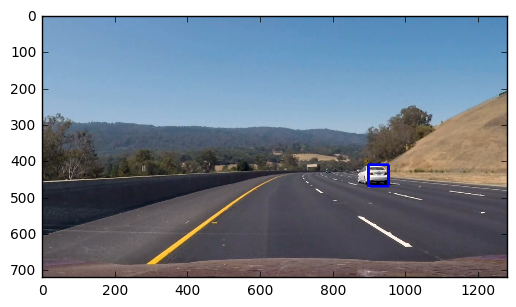

total samples: 1663 total windows: 1663
Finished detection in 8.36 seconds
Detected boxes with cars: 28


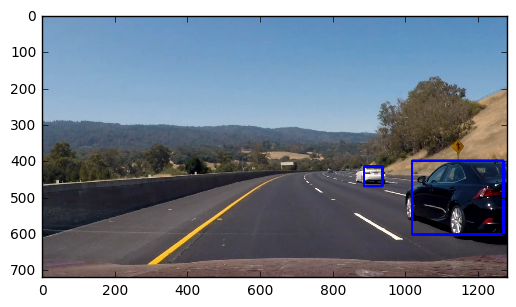

total samples: 1663 total windows: 1663
Finished detection in 8.42 seconds
Detected boxes with cars: 19


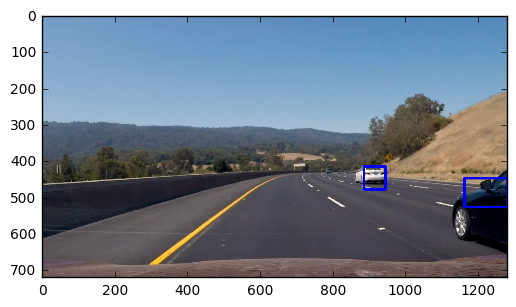

In [324]:
from features import SupportVectorClassifier
from features import ImageSampler
from features import HeatMapFilter

%load_ext autoreload
%autoreload 2

    
def view_some_samples(samples, view_count):
    random_samples = []
    for i in range(0, view_count):
        random_samples.append(random.choice(samples))
    show_images(images=random_samples, per_row=5)
    
def detect_cars(samples, windows, classifier):
    start = time.time()
    cars = []
    car_windows = []
    samples_features = feature_extractor.get_features(samples)
    for idx, feature_sample in enumerate(samples_features):
        prediction = classifier.predict(feature_sample)
        if prediction == 1:
            cars.append(samples[idx])
            car_windows.append(windows[idx])
    print("Finished detection in {:1.2f}".format(time.time() - start), "seconds")
    return cars, car_windows
            
img = cv2.imread('project_video_images/frame255.jpg'.format(img_number))
# image_numbers = [255,525,345, 615, 945, 10201, 1920]
image_numbers = [1920,720, 690]
sampler = ImageSampler(img_shape=img.shape)
heatmap_filter = HeatMapFilter()

finished_images = []
for img_number in image_numbers:
    img = cv2.imread('project_video_images/frame{:d}.jpg'.format(img_number))
#     img_file = 'test_images/test{:d}.jpg'.format(img_number)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    
    samples, windows = sampler.sample_image(img)
    print("total samples:", len(samples), "total windows:", len(windows))
    # view_some_samples(samples, 20)

    cars, car_boxes = detect_cars(samples, windows, classifier)
    # show_images(cars[:20], per_row=4, main_title="Some Detected Cars")

    print("Detected boxes with cars:", len(cars))

    detected_cars_img = draw_boxes(img, car_boxes, color=(0, 0, 255), thick=6)
    labeled_boxes = heatmap_filter.filter_boxes(img.shape, car_boxes)
    
    for bbox in labeled_boxes:
        img = cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    
    plt.imshow(img)
    plt.show()
#     finished_images.append(img)
    
# show_images(finished_images)

In [325]:
class VideoProcessor:
    def __init__(self, classifier):
        self.sampler = None
        self.heatmap_filter = HeatMapFilter()
        self.classifier = classifier
        self.last_labeled_boxes = []
        self.current_frame_number = 0

        
    def detect_cars(self, samples, windows):

        cars, car_windows = [], []
    
        samples_features = feature_extractor.get_features(samples)
        
        for idx, feature_sample in enumerate(samples_features):
            prediction = self.classifier.predict(feature_sample)
            if prediction == 1:
                cars.append(samples[idx])
                car_windows.append(windows[idx])

        return cars, car_windows

        
    def process_image(self, img):
        out_img = img
        if self.sampler is None:
            self.sampler = ImageSampler(img_shape=img.shape)
        
        # update labled boxes every 15 frames
        if self.current_frame_number % 15 == 0:
            samples, windows = self.sampler.sample_image(img)  #TODO, change to use HOG?
            cars, car_boxes = self.detect_cars(samples, windows)
            self.last_labeled_boxes = heatmap_filter.filter_boxes(img.shape, car_boxes)
        
        # draw boxes
        for bbox in self.last_labeled_boxes:
            out_img = cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
        
        self.current_frame_number += 1
        
        return out_img
        
    # Single function that can extract features using hog sub-sampling and make predictions
    def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

        draw_img = np.copy(img)
        img = img.astype(np.float32)/255

        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

        return draw_img

processor = VideoProcessor(classifier)


from moviepy.editor import VideoFileClip

output_video_filename = 'processed_project_video.mp4'
input_video = VideoFileClip('project_video.mp4')
out_clip = input_video.fl_image(processor.process_image) 
%time out_clip.write_videofile(output_video_filename, audio=False)

[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4


100%|█████████▉| 1260/1261 [12:31<00:00,  1.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_project_video.mp4 

CPU times: user 12min 3s, sys: 5.48 s, total: 12min 9s
Wall time: 12min 32s


# Sliding Windows

In [ ]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
    

windows = []
# windows = my_slider(img, x_start_stop=[0, 1280], center_y_start_stop=(550, 400), 
#                     starting_window_size=(280, 280), xy_shift_amount=(.33, .10))

windows = slide_window(img, x_start_stop=[50, None], y_start_stop=[375, 500], 
                    xy_window=(64, 64), xy_overlap=(0.4, 0.4))

windows = slide_window(img, x_start_stop=[50, None], y_start_stop=[300, 600], 
                    xy_window=(150, 150), xy_overlap=(0.65, 0.65))
# windows = slide_window(img, x_start_stop=[20, None], y_start_stop=[300, 700], 
#                     xy_window=(225, 225), xy_overlap=(0.7, 0.75))
# windows += slide_window(img, x_start_stop=[None, None], y_start_stop=[300, 900], 
#                     xy_window=(300, 300), xy_overlap=(0.75, 0.75))
print(len(windows))

img = draw_boxes(img, windows)

plt.imshow(img)
plt.show()

In [ ]:
import time
